# **Racial-Bais in reaction against complaints**

**Disparities in Disciplinary Actions against Internal and Extrnal complaints based on the broader racial diversity**

In our Checkpoint 3 submission, we proved the disparity between the actions taken against Internal and External complaints based on the diversity of the districts using hypothesis testing.

To reiterate, the general trend is that the percentage of officers who were disciplined (officers against whom allegations were made and were disciplined) is higher for internal complaints than that for external complaints. This could mean that the department gives more weight to the complaints by fellow officers rather than citizens. This is expected in general due to the scale of internal vs external complaints. (Internal: 5138| External: 13095)

However, the ratio between these disciplinary actions ideally should be same between districts. Thats were observed disparities in the numbers ranging from 1.07 and 1.90 with a mean of 1.45 and standard deviation of 0.22. There are only 4 districts(Wentworth, Near North, Morgan park, Grand Crossing) that have a comparable ratio of disciplined officers for both internal and external complaints. Which means that these districts are giving equal importance to the civilian complaints as well.

Through the following analysis using graph analytics we want to understand the relationship between the investigators and misconduct alleged officers with respect to the closeness and racial makeup of officers and investigators.

---


# **Installing required modules**


In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

In [2]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [3]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd
import psycopg2

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# **Extracting the data**

In [4]:
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [5]:
cursor = conn.cursor()

In [6]:
edges_query = "SELECT dia.investigator_id as src, doa.officer_id as dst, COUNT(DISTINCT doa.allegation_id) as relationship from data_investigatorallegation dia join data_officerallegation doa on dia.allegation_id = doa.allegation_id group by src, dst order by relationship desc"

In [29]:
nodes_query = "select doa_trr.off_id id, doff.race off_race, count(distinct(unique_allegation_ids)) allegation_count from data_officer as doff join (SELECT trr.officer_id as off_id, doa.allegation_id as unique_allegation_ids FROM data_officerallegation doa JOIN trr_trr trr ON trr.officer_id = doa.officer_id group by off_id, unique_allegation_ids ) as doa_trr on doa_trr.off_id = doff.id group by doa_trr.off_id, off_race;"

In [19]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 186983

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

shape is: 186983
(186983, 3)


In [30]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 10454

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

shape is: 10454
(10454, 3)


In [21]:
edges_ = spark.createDataFrame(df_edges)

In [31]:
nodes = spark.createDataFrame(df_nodes)

In [32]:
cpdb = GraphFrame(nodes, edges_)

# **Showing the graph of the Investigator and Officers**

In [72]:
cpdb.vertices.sort(['allegation_count'],ascending=False).show()

+-----+--------+----------------+
|   id|off_race|allegation_count|
+-----+--------+----------------+
| 8562|   White|             175|
|21837|   Black|             137|
|17816|   White|             136|
| 8138|   Black|             132|
|21468|   White|             127|
|31631|   White|             121|
|29033|   White|             117|
|32166|   Black|             110|
| 4807|   Black|             109|
|32164|   Black|             106|
|31119|   White|             106|
| 2015|   White|             102|
|32265|   White|             102|
|10890|   Black|             102|
| 3897|   White|             100|
|11634|   White|              97|
|23265|Hispanic|              96|
|25306|Hispanic|              94|
|16567|Hispanic|              93|
|17041|   Black|              93|
+-----+--------+----------------+
only showing top 20 rows



In [38]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw(g, with_labels=True, arrows = True, node_color='grey')

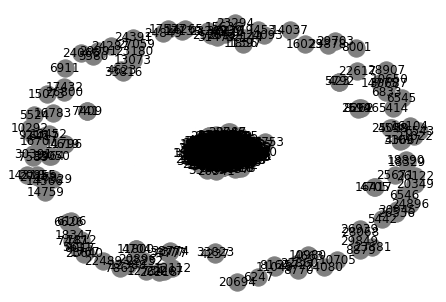

In [39]:
plot_graph(cpdb)

We can see that there are some officers and investigator pairs which have closer relationships whereas others are disparate

In [71]:
cpdb.edges.sort(['relationship'],ascending=False).show()

+----+-----+------------+
| src|  dst|relationship|
+----+-----+------------+
|2538|32166|          24|
|3886|23841|          24|
|3886| 8562|          23|
|2538|12478|          21|
|3886| 3454|          20|
|3278| 2725|          20|
|1718|27415|          20|
|2151|17041|          19|
|1718|32016|          19|
|2376|25898|          19|
|1718|21098|          19|
|3255|11266|          18|
|3278|32164|          17|
|2970|21887|          17|
|1718|32172|          17|
|3886|18076|          17|
|3836| 8386|          17|
|3836| 8620|          16|
|2970| 3764|          16|
|2970|31853|          16|
+----+-----+------------+
only showing top 20 rows



In [115]:
wh_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)

wh_cpdb.vertices.filter("off_race == 'White'").orderBy('allegation_count', ascending=False).orderBy('pagerank', ascending=False).show()

+-----+--------+----------------+------------------+
|   id|off_race|allegation_count|          pagerank|
+-----+--------+----------------+------------------+
|15228|   White|              76| 3.717542092859763|
| 9813|   White|              12| 3.663266521496003|
|30447|   White|              36|  3.20631465969362|
|20975|   White|              19|3.1798205388205947|
|31631|   White|             121| 3.095765941443228|
|21124|   White|              57|2.9889291854862017|
|10152|   White|              51|2.9865489593642702|
|32259|   White|              25|2.9673749770442464|
| 8431|   White|              47|2.8816453383787013|
| 9952|   White|              43|2.8172031839292937|
|14969|   White|              35| 2.794508174797917|
| 8578|   White|              68|2.7942926657355516|
| 1744|   White|              22| 2.781625603852393|
| 5094|   White|              53|2.7350484831643866|
| 6264|   White|              19| 2.723872434129633|
|20057|   White|              34|2.70185136725

In [116]:
wh_cpdb.edges.orderBy('weight', ascending = False).show()

+----+-----+------------+------+
| src|  dst|relationship|weight|
+----+-----+------------+------+
| 220|24491|           1|   1.0|
|1342|19671|           1|   1.0|
| 597|20975|           1|   1.0|
|1278|32414|           1|   1.0|
|1284|10119|           1|   1.0|
|  82|15929|           1|   1.0|
|1346|19418|           1|   1.0|
| 282|24724|           1|   1.0|
| 296| 6949|           1|   1.0|
| 338| 3585|           1|   1.0|
| 769|23148|           1|   1.0|
|1439| 3941|           1|   1.0|
|1272| 5684|           1|   1.0|
| 588| 4333|           1|   1.0|
| 635|23763|           1|   1.0|
| 599|26278|           1|   1.0|
| 385|17196|           1|   1.0|
| 438| 7699|           1|   1.0|
|  26| 4250|           1|   1.0|
| 574| 7987|           1|   1.0|
+----+-----+------------+------+
only showing top 20 rows



In [119]:
hs_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)

hs_cpdb.vertices.filter("off_race == 'Hispanic'").orderBy('allegation_count', ascending=False).orderBy('pagerank', ascending=False).show()

+-----+--------+----------------+------------------+
|   id|off_race|allegation_count|          pagerank|
+-----+--------+----------------+------------------+
|19407|Hispanic|              70|  3.27675798754739|
|23265|Hispanic|              96|2.9657841398254603|
|19985|Hispanic|              12| 2.904318312817501|
|32142|Hispanic|              53|  2.87751003293898|
|31598|Hispanic|              25| 2.814686446018932|
| 1277|Hispanic|              31|2.7050824460173613|
|24426|Hispanic|              73|2.5685685099935753|
|12009|Hispanic|              24|2.4727832891674475|
| 4450|Hispanic|              11| 2.389846041403948|
|21581|Hispanic|              13|2.3572642480737804|
|25273|Hispanic|              35|2.2168225406694715|
|12074|Hispanic|              80|2.1750844721000884|
|24431|Hispanic|              62|2.1374410047939647|
|18841|Hispanic|              14|2.1070320123720356|
|  879|Hispanic|               7|  2.10245507511925|
|27084|Hispanic|               6|2.10123150014

In [120]:
hs_cpdb.edges.orderBy('weight', ascending = False).show()

+----+-----+------------+------+
| src|  dst|relationship|weight|
+----+-----+------------+------+
| 220|24491|           1|   1.0|
|1342|19671|           1|   1.0|
| 597|20975|           1|   1.0|
|1278|32414|           1|   1.0|
|1284|10119|           1|   1.0|
|  82|15929|           1|   1.0|
|1346|19418|           1|   1.0|
| 282|24724|           1|   1.0|
| 296| 6949|           1|   1.0|
| 338| 3585|           1|   1.0|
| 769|23148|           1|   1.0|
|1439| 3941|           1|   1.0|
|1272| 5684|           1|   1.0|
| 588| 4333|           1|   1.0|
| 635|23763|           1|   1.0|
| 599|26278|           1|   1.0|
| 385|17196|           1|   1.0|
| 438| 7699|           1|   1.0|
|  26| 4250|           1|   1.0|
| 574| 7987|           1|   1.0|
+----+-----+------------+------+
only showing top 20 rows



In [117]:
bl_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)

bl_cpdb.vertices.filter("off_race == 'Black'").orderBy('allegation_count', ascending=False).orderBy('pagerank', ascending=False).show()

+-----+--------+----------------+------------------+
|   id|off_race|allegation_count|          pagerank|
+-----+--------+----------------+------------------+
| 4844|   Black|              77|3.5900982001628536|
|29842|   Black|              56| 2.862045328338858|
|20207|   Black|              59|2.7957411525233447|
| 8475|   Black|              32|2.7861969615415174|
|12634|   Black|              29|2.6822397441866097|
| 4807|   Black|             109| 2.638483046194086|
|17041|   Black|              93|2.6313026459840607|
|23148|   Black|              25|2.6298736396727644|
|23004|   Black|              61| 2.571312803674856|
| 5239|   Black|              33| 2.545319843939723|
|29831|   Black|              74|2.5207568182702587|
|23205|   Black|              84|2.5141868905979616|
|32414|   Black|              29| 2.496895893574152|
|  646|   Black|              35|2.4653491806354033|
| 3216|   Black|              73|2.4355152006016914|
|21837|   Black|             137|2.41303219408

In [118]:
bl_cpdb.edges.orderBy('weight', ascending = False).show()

+----+-----+------------+------+
| src|  dst|relationship|weight|
+----+-----+------------+------+
|4467|33758|           1|   1.0|
|4563|33740|           1|   1.0|
|4530|21201|           1|   1.0|
|1815|28602|           1|   1.0|
|4435| 3439|           1|   1.0|
|2583|23908|           1|   1.0|
|4517|30910|           1|   1.0|
|4010|33720|           1|   1.0|
|1061|30707|           2|   1.0|
|4782|12084|           1|   1.0|
|1113|23205|           2|   1.0|
|2126| 2088|           1|   1.0|
|3920|26813|           1|   1.0|
|2127|23456|           1|   1.0|
|4320|17415|           1|   1.0|
|2290| 8257|           1|   1.0|
|4497| 3735|           1|   1.0|
|4370| 7982|           1|   1.0|
|2967|10554|           1|   1.0|
|3889| 6451|           1|   1.0|
+----+-----+------------+------+
only showing top 20 rows



In [65]:
ap_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)

ap_cpdb.vertices.filter("off_race == 'Asian/Pacific'").orderBy('allegation_count', ascending=False).orderBy('pagerank', ascending=False).show()

+-----+-------------+----------------+------------------+
|   id|     off_race|allegation_count|          pagerank|
+-----+-------------+----------------+------------------+
|14215|Asian/Pacific|              36|2.5692802328047857|
|23139|Asian/Pacific|               9| 2.218829680515077|
| 1270|Asian/Pacific|              14|2.0373227843611175|
|32191|Asian/Pacific|              14|1.9889782045666082|
|23404|Asian/Pacific|              11|1.8811527874671696|
|14617|Asian/Pacific|              13|1.8425287525814231|
|25169|Asian/Pacific|              12|1.7556927467754493|
| 1756|Asian/Pacific|               9| 1.753928909518317|
|32018|Asian/Pacific|              29|1.7149503817338005|
| 4250|Asian/Pacific|              10|1.7010693371791208|
| 4549|Asian/Pacific|               6|1.6923181908446465|
|13937|Asian/Pacific|              61| 1.678618679781732|
|23190|Asian/Pacific|              13|1.6582944380345228|
|30568|Asian/Pacific|              15|1.6106401145644074|
|16437|Asian/P

In [113]:
ap_cpdb.edges.orderBy('weight', ascending = False).show()

+----+-----+------------+------+
| src|  dst|relationship|weight|
+----+-----+------------+------+
| 220|24491|           1|   1.0|
|1342|19671|           1|   1.0|
| 597|20975|           1|   1.0|
|1278|32414|           1|   1.0|
|1284|10119|           1|   1.0|
|  82|15929|           1|   1.0|
|1346|19418|           1|   1.0|
| 282|24724|           1|   1.0|
| 296| 6949|           1|   1.0|
| 338| 3585|           1|   1.0|
| 769|23148|           1|   1.0|
|1439| 3941|           1|   1.0|
|1272| 5684|           1|   1.0|
| 588| 4333|           1|   1.0|
| 635|23763|           1|   1.0|
| 599|26278|           1|   1.0|
| 385|17196|           1|   1.0|
| 438| 7699|           1|   1.0|
|  26| 4250|           1|   1.0|
| 574| 7987|           1|   1.0|
+----+-----+------------+------+
only showing top 20 rows



In [63]:
naan_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)

naan_cpdb.vertices.filter("off_race == 'Native American/Alaskan Native'").orderBy('allegation_count', ascending=False).orderBy('pagerank', ascending=False).show()

+-----+--------------------+----------------+------------------+
|   id|            off_race|allegation_count|          pagerank|
+-----+--------------------+----------------+------------------+
| 7244|Native American/A...|              60|1.9022444103604794|
| 7987|Native American/A...|              28| 1.866906359284925|
|   75|Native American/A...|              27|1.5138811086488675|
| 7437|Native American/A...|              29|1.3996341605135865|
|17365|Native American/A...|              11|1.2957131647207072|
|16847|Native American/A...|               6|  1.27218223352377|
|12883|Native American/A...|               7|1.2172683033789289|
|25709|Native American/A...|               3|1.1742793439843047|
|10583|Native American/A...|              32|1.1114457527622257|
| 8041|Native American/A...|              17| 1.090587526823161|
| 2183|Native American/A...|              16|1.0789114516919116|
|22160|Native American/A...|               9|1.0770267370015256|
|21140|Native American/A.

In [114]:
naan_cpdb.edges.orderBy('weight', ascending = False).show()

+----+-----+------------+------+
| src|  dst|relationship|weight|
+----+-----+------------+------+
|4467|33758|           1|   1.0|
|4563|33740|           1|   1.0|
|4530|21201|           1|   1.0|
|1815|28602|           1|   1.0|
|4435| 3439|           1|   1.0|
|2583|23908|           1|   1.0|
|4517|30910|           1|   1.0|
|4010|33720|           1|   1.0|
|1061|30707|           2|   1.0|
|4782|12084|           1|   1.0|
|1113|23205|           2|   1.0|
|2126| 2088|           1|   1.0|
|3920|26813|           1|   1.0|
|2127|23456|           1|   1.0|
|4320|17415|           1|   1.0|
|2290| 8257|           1|   1.0|
|4497| 3735|           1|   1.0|
|4370| 7982|           1|   1.0|
|2967|10554|           1|   1.0|
|3889| 6451|           1|   1.0|
+----+-----+------------+------+
only showing top 20 rows



In [64]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM


msgToSrc = AM.dst["allegation_count"]
msgToDst = AM.src["allegation_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['summedAllegations'],ascending=False).show()

+----+-----------------+
|  id|summedAllegations|
+----+-----------------+
|1718|            35240|
|1715|            34965|
|1928|            30945|
|3018|            30473|
|1723|            28036|
|1419|            27125|
|2375|            25254|
|3255|            24556|
|1930|            24544|
|1460|            21279|
|1434|            18715|
|1440|            18410|
|1666|            16950|
|1630|            16132|
|2322|            15132|
|1623|            14862|
|3201|            14567|
|1679|            13902|
|2741|            13341|
|1656|            13246|
+----+-----------------+
only showing top 20 rows



In [74]:
cpdb.inDegrees.sort(['inDegree'],ascending=[0]).show()

+-----+--------+
|   id|inDegree|
+-----+--------+
| 3764|     108|
|16385|      98|
| 8138|      88|
|25799|      87|
|17372|      87|
|11190|      87|
| 3808|      86|
| 3897|      85|
| 8562|      85|
|31631|      84|
|32265|      83|
|12074|      82|
|21468|      81|
|15228|      80|
| 9309|      79|
| 4118|      79|
|31882|      74|
| 5193|      74|
|17647|      74|
|25963|      73|
+-----+--------+
only showing top 20 rows



In [75]:
cpdb.outDegrees.sort(['outDegree'],ascending=[0]).show()

+----+---------+
|  id|outDegree|
+----+---------+
|1438|     2660|
|2985|     2455|
|1657|     2421|
|2724|     2384|
|2376|     2130|
|1919|     2073|
|1715|     1831|
|1718|     1695|
|1697|     1650|
|1595|     1568|
|2970|     1544|
|3018|     1542|
|1923|     1522|
|2472|     1474|
|1419|     1436|
|1928|     1420|
|3270|     1413|
|3062|     1335|
|1445|     1330|
|3183|     1321|
+----+---------+
only showing top 20 rows



In [76]:
cpdb.degrees.sort(['Degree'],ascending=[0]).show()

+----+------+
|  id|degree|
+----+------+
|1438|  2661|
|2985|  2456|
|1657|  2421|
|2724|  2385|
|2376|  2130|
|1919|  2073|
|1715|  1867|
|1718|  1731|
|1697|  1650|
|1595|  1570|
|3018|  1554|
|2970|  1544|
|1923|  1522|
|2472|  1474|
|1419|  1439|
|1928|  1426|
|3270|  1413|
|3062|  1335|
|1445|  1330|
|3183|  1321|
+----+------+
only showing top 20 rows



In [101]:
g1 = cpdb.filterVertices("off_race == 'White'").filterEdges("relationship > 10").dropIsolatedVertices()
g1.edges.show()

+----+-----+------------+
| src|  dst|relationship|
+----+-----+------------+
|2492|31847|          11|
|3255| 1553|          12|
|3255|10724|          11|
|3255|14061|          11|
|3255|16699|          11|
|2815|25039|          15|
|2815| 5193|          11|
|2815|17369|          11|
|2375|16396|          12|
+----+-----+------------+



In [79]:
g1 = cpdb.filterVertices("off_race == 'Black'").filterEdges("relationship > 10").dropIsolatedVertices()
g1.edges.show()

+----+-----+------------+
| src|  dst|relationship|
+----+-----+------------+
|1723|23153|          12|
|3278|32164|          17|
|1718|32164|          16|
|1718|22176|          11|
+----+-----+------------+



In [85]:
g1 = cpdb.filterVertices("off_race == 'Hispanic'").filterEdges("relationship > 4").dropIsolatedVertices()
g1.edges.show()

+----+-----+------------+
| src|  dst|relationship|
+----+-----+------------+
|1419|21492|           5|
+----+-----+------------+



In [95]:
g1 = cpdb.filterVertices("off_race == 'Asian/Pacific'").dropIsolatedVertices()
g1.edges.show()

+----+-----+------------+
| src|  dst|relationship|
+----+-----+------------+
|2244| 2201|           1|
|4066|23139|           1|
| 772| 4473|           1|
+----+-----+------------+



In [94]:
g1 = cpdb.filterVertices("off_race == 'Native American/Alaskan Native'").dropIsolatedVertices()
g1.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
+---+---+------------+

